# Logistic regression

The journey to deep neural networks starts with logistic regression
- it's the simplest neural network possible
- training algorithm is pretty much the same

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

# General supervised learning

- dataset $(x_i, y_i), i=1\ldots N$
- $x_i \in R^p$ are samples
- $y_i$ are discrete labels

build some predictor $\hat y_i = f_\theta(x)$

# Toy dataset
A simple dataset, which is almost linearly separable

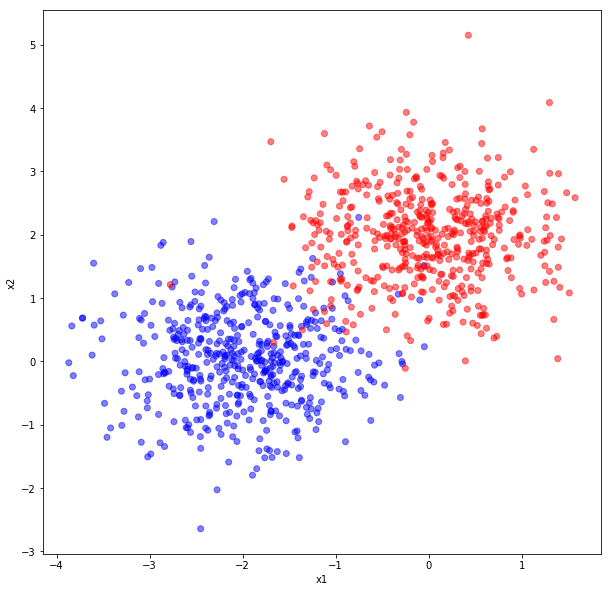

In [4]:
from talk_utils import create_lin_data, create_nonlin_data
X,y = create_lin_data(500)  # X,y = create_nonlin_data(500)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, cmap=plt.cm.bwr);
plt.xlabel('x1')
plt.ylabel('x2');

# Logistic regression
- most simple linear classifier
    - $p_i = \sigma(W x_i + b$)
    - $y_i \sim Bernoulli(p_i)$


- **linear** decision boundary in input space
![logreg](images/MLP/logreg.png)

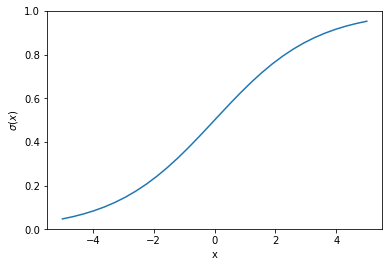

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def logreg(x, W, b):
    return sigmoid(x@W + b)

plt.plot(np.linspace(-5,5,30), sigmoid(np.linspace(-3,3,30)));
plt.xlabel('x'); plt.ylabel('$\sigma(x)$');

## a simple 2D example

In [53]:
def _grid_logreg(W,b):
    x_range = np.linspace(-4,4,50)
    y_range = np.linspace(-4,4,50)
    P = np.zeros((50,50))
    for i,ii in enumerate(y_range):
        for j,jj in enumerate(x_range):
            P[i,j] = logreg(np.array([ii,jj]).reshape(1,2), W,b)
    return x_range, y_range, P

def plot_2d_logreg(W,b):
    x_range, y_range, P = _grid_logreg(W,b)
    plt.figure(figsize=(6,6))
    plt.pcolor(x_range, y_range, P, cmap=plt.cm.bwr)
    plt.clim(0,1)
    plt.colorbar()
    plt.xlabel('x1')
    plt.ylabel('x2')

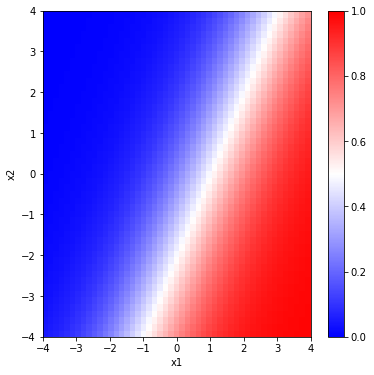

In [12]:
# parameters of the logistic regression:
W = np.array([[-0.5, 1]]).T
b = np.array(-1).reshape(1,-1)

plot_2d_logreg(W,b)

## Training a logistic regression model
aka fitting the model to the data

- minimize a **loss function** $L(\theta)$ 
    - likelihood of the data under the logistic regression model (just a Bernoulli): 
    $$like(X,y| \theta) = \prod_{i=1\ldots N} p_i^{y_i} \cdot (1-p_i)^{1-y_i}$$
    - log likelihood: $$loglike(X,y| \theta) = \sum_{i=1\ldots N} y_i \log(p_i) +  (1-y_i) \log(1-p_i)$$
    - turns out that this is (up to sign) the same as the *cross entropy loss*
    
    
- minimization via **gradient descend**:
    - $\theta_{t+1} := \theta_{t} + \eta \cdot \partial_\theta L(\theta)$
    
    
- for our logistic regression example:
    - $\partial_W L(W,b) = \sum_{i=1\ldots N} y_i \cdot (1-p_i) \cdot \partial_W (W x_i+b) + (1-y_i) \cdot p_i \cdot (-1) \cdot\partial_W (W x_i+b)$
    - $\partial_W L(W,b) = \sum_{i=1\ldots N} y_i \cdot (1-p_i) \cdot x_i - (1-y_i) \cdot p_i \cdot x_i$
    - $\partial_W L(W,b) = \sum_{i=1\ldots N} (y_i \cdot (1-p_i) - (1-y_i) \cdot p_i)\cdot x_i$
    - using $\partial_x \sigma(x) = \sigma(x) \cdot (1- \sigma(x))$
    
    - analogous: $\partial_b L(W,b) = \sum_{i=1\ldots N} y_i \cdot (1-p_i) - (1-y_i) \cdot p_i$
    
**Note**: For logistic regression, there's better way to fit than gradient descend (IRLS).

In [114]:
def logreg_gradW(x,y,W,b):
    "gradient wrt to W"
    p = logreg(x, W, b)
    
    if True: # slow but more explicit variant
        gradients=[]
        for i in range(len(y)): # for each datapoint calculate the gradient term
            gradients.append(y[i]*(1-p[i])*x[i] - (1-y[i])*p[i] *x[i])
        gradients = np.stack(gradients).sum(0,keepdims=True ).T
    else:
        gradients = (y.reshape(-1,1)*(1-p)*x - (1-y.reshape(-1,1))*p*x).sum(0,keepdims=True).T
    
    gradients = - gradients # sign flip due to likelihood vs loss
    return gradients

def logreg_gradb(x,y,W,b):
    "gradient wrt to b"
    p = logreg(x, W, b)
    
    if False:
        gradients=[]
        for i in range(len(y)):
            gradients.append(y[i]*(1-p[i]) - (1-y[i])*p[i])
        gradients = np.stack(gradients).sum(0,keepdims=True ).T
    else:
        gradients = (y.reshape(-1,1)*(1-p) - (1-y.reshape(-1,1))*p).sum(0,keepdims=True).T
    
    gradients = - gradients # sign flip due to likelihood vs loss
    return gradients

def logreg_loss(x,y,W,b):
    "the cross entropy loss"
    p = logreg(x, W, b)
    loss = - np.sum(y * np.log(p) + (1-y) * np.log(1-p))
    return loss

In [117]:
W0 = np.array([[5],[-2]])  # initial condition
b0 = np.array([-9])         # initial condition
eta = 0.005                # learning rate
W_list = [W0]
b_list = [b0]
for i in range(150):       # 200 steps of gradient descend
    Wold = W_list[-1]
    bold = b_list[-1]
    Wnew = Wold - eta*logreg_gradW(X,y,Wold, bold )
    bnew = bold - eta*logreg_gradb(X,y,Wold, bold )
    W_list.append(Wnew)
    b_list.append(bnew)
    
W_list = np.stack(W_list)[:,:,0]

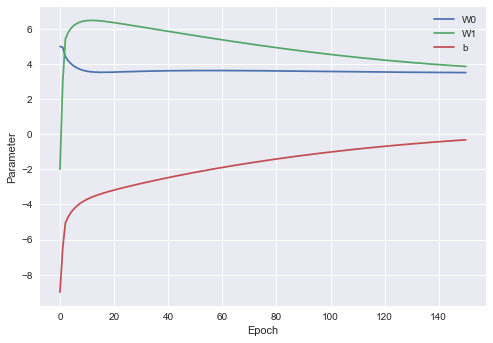

In [129]:
plt.plot(W_list);
plt.plot(b_list);
plt.xlabel('Epoch')
plt.ylabel('Parameter')
plt.legend(['W0', 'W1', 'b'])

# Visualization of the decision boundary while learning

In [ ]:
from talk_plottingutils import *
import holoviews as hv
hv.extension('bokeh')

In [93]:
Pgrid_list = [_grid_logreg(ww,bb) for ww,bb in zip(W_list, b_list)]

In [120]:
hv_hmap = hv_plot_stack(Pgrid_list, range(len(Pgrid_list)))
hv_scatter1= hv.Points(X[y==0])
hv_scatter2= hv.Points(X[y==1])

In [ ]:
%%output size=160
%%opts Image style(cmap='bwr_r')
%%opts Points (marker='o' size=10 alpha=0.5 line_color='k')
hv_hmap * hv_scatter2 * hv_scatter1